In [1]:
import os
import numpy as np  
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential

In [2]:
DATA_DIR = 'E:/Data/dataset/PetImages'  # Dossier parent avec dog/ et cat/
IMG_SIZE = (150, 150)                # Taille des images
BATCH_SIZE = 32                      # Taille des batches
VAL_SPLIT = 0.3                      # 30% pour la validation
SEED = 42                          # Pour la reproductibilité

In [3]:
dog_dir = os.path.join(DATA_DIR, 'dog')
cat_dir = os.path.join(DATA_DIR, 'cat')
dog_images = [f for f in os.listdir(dog_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
cat_images = [f for f in os.listdir(cat_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    

In [4]:
import os
from PIL import Image

for folder in ["cat", "dog"]:
    folder_path = os.path.join(DATA_DIR, folder)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path)
            img.verify()  # vérifie l'image
        except Exception as e:
            print("Image supprimée :", file_path)
            os.remove(file_path)


e:\Data\script\venv\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [5]:
print(f"Nombre d'images de chiens: {len(dog_images)}")
print(f"Nombre d'images de chats: {len(cat_images)}")

Nombre d'images de chiens: 12499
Nombre d'images de chats: 12499


In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,           # Normalisation [0,1]
        rotation_range=20,        # Rotation aléatoire
        width_shift_range=0.1,    # Déplacement horizontal
        height_shift_range=0.1,   # Déplacement vertical
        shear_range=0.1,          # Cisaillement
        zoom_range=0.1,           # Zoom aléatoire
        horizontal_flip=True,     # Retournement horizontal
        brightness_range=[0.9, 1.1], # Variation de luminosité
        fill_mode='nearest',      # Remplissage des bords
        validation_split=VAL_SPLIT  # Split pour validation
    )
    
# Préprocessing pour la validation (sans augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT
)

# Générateur d'entraînement
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',      # binary pour 2 classes
    shuffle=True,
    seed=SEED,
    color_mode='rgb',         # Images couleur
    subset='training'         # Sous-ensemble d'entraînement
)

# Générateur de validation
validation_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,           # Pas de shuffle pour la validation
    color_mode='rgb',
    subset='validation'      # Sous-ensemble de validation
)

Found 17500 images belonging to 2 classes.
Found 7498 images belonging to 2 classes.


In [7]:
modele = Sequential()

# Premiere couche de convolution
modele.add(Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))

# Couche de pooling
modele.add(MaxPooling2D(pool_size=(2,2)))

# Regularisation
modele.add(Dropout(0.2))

# Deuxieme couche de convolution
modele.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

# Couche de pooling
modele.add(MaxPooling2D(pool_size=(2,2)))

# Regularisation
modele.add(Dropout(0.2))

# Couche de flattening
modele.add(Flatten())

# Couche dense
modele.add(Dense(32,activation='relu'))

# Couche de sortie
modele.add(Dense(1,activation='sigmoid'))

modele.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

print(modele.summary())


e:\Data\script\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     2,654,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,731,649 (10.42 MB)

 Trainable params: 2,731,649 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:

for folder in ["cat", "dog"]:
    path = os.path.join(DATA_DIR, folder)
    print(folder, ":", len(os.listdir(path)), "images")

cat : 12499 images
dog : 12499 images


In [10]:
modele.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1614s 3s/step - accuracy: 0.5596 - loss: 0.6847 - val_accuracy: 0.5718 - val_loss: 0.6843
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1325s 2s/step - accuracy: 0.5713 - loss: 0.6790 - val_accuracy: 0.5795 - val_loss: 0.6749
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1341s 2s/step - accuracy: 0.6127 - loss: 0.6591 - val_accuracy: 0.6452 - val_loss: 0.6295
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 2418s 4s/step - accuracy: 0.6438 - loss: 0.6385 - val_accuracy: 0.6620 - val_loss: 0.6163
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1283s 2s/step - accuracy: 0.6637 - loss: 0.6196 - val_accuracy: 0.6897 - val_loss: 0.5890
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1219s 2s/step - accuracy: 0.6753 - loss: 0.6099 - val_accuracy: 0.7003 - val_loss: 0.5801
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1528s 3s/step - accuracy: 0.6986 - loss: 0.5782 - val_accuracy: 0.7077 - val_loss: 0.5691
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 17271s 32s/step - accuracy: 0.7185 - loss: 0.5540 

In [11]:
prediction = modele.predict(validation_generator)

235/235 ━━━━━━━━━━━━━━━━━━━━ 110s 456ms/step


In [12]:
prediction

array([[0.1676739 ],
       [0.1195331 ],
       [0.52300155],
       ...,
       [0.9985441 ],
       [0.95623446],
       [0.38385907]], shape=(7498, 1), dtype=float32)

In [13]:
images, labels = next(validation_generator)

In [14]:
import matplotlib.pyplot as plt

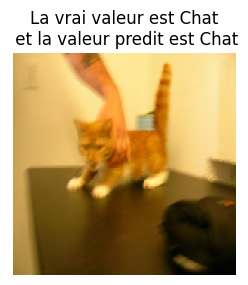

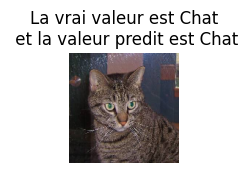

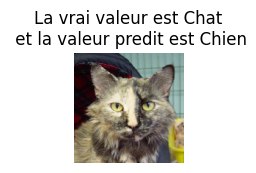

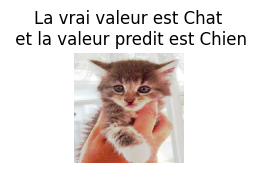

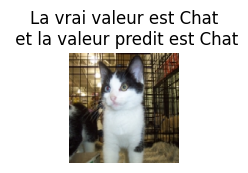

In [15]:
plt.figure(figsize=(12, 8))
for i in range(min(5, len(images))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    class_name = 'Chien' if labels[i] > 0.5 else 'Chat'
    predict = 'Chien' if prediction[i] > 0.5 else 'Chat'
    plt.title(f'La vrai valeur est {class_name}\n et la valeur predit est {predict}')
    plt.axis('off')


    plt.tight_layout()
    plt.show()

## Score

In [16]:
len(prediction),len(labels)

(7498, 32)

In [18]:
all_labels = []
image_vis = []

for i in range(len(validation_generator)):
    image,label = next(validation_generator)
    all_labels = all_labels + list(label)
    image_vis.append(image)

print(len(all_labels))  # Devrait être égal au nombre total d'images de validation

7498


In [19]:
np.unique(np.array(all_labels), return_counts=True)

(array([0., 1.], dtype=float32), array([3749, 3749]))

In [20]:
true = 0
false = 0
false_images = [] # (batch, index)
prediction = [1 if p > 0.5 else 0 for p in prediction]
index = -1

batch_image = 0
for i,j in zip(all_labels,prediction):
    if index == 32:
        batch_image += 1
        index = -1
    index += 1
    if i == j:
        true += 1
    else:
        false += 1
        false_images.append((batch_image, index))


print(true,false)
print(true/(true+false))  # Accuracy

5873 1625
0.7832755401440384


In [21]:
image[0].shape

(150, 150, 3)

In [22]:
image_vis[0][0].shape

(150, 150, 3)

In [23]:
def image_visualisation(im_dir):
    img = keras_image.load_img(im_dir, target_size=(150,150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()  

In [31]:
def prediction_func(im_dir):
    img = keras_image.load_img(im_dir, target_size=(150,150))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter dimension batch
    img_array = img_array / 255.0  # Normalisation [0, 1]
    prediction = modele.predict(img_array, verbose=0)
    if prediction < 0.5:
        return f"C'est un chat avec une probabilité de {1-prediction[0][0]:.2f}"
    else:
        return f"C'est un chien avec une probabilité de {prediction[0][0]:.2f}"

In [32]:
image_dir ='E:/Data/dataset/PetImages/image2.jpg'

In [33]:
print(prediction_func(image_dir))

C'est un chat avec une probabilité de 0.65
